In [48]:
import numpy as np
import logging
import pyLDAvis.gensim
import json
import pandas as pd
import matplotlib.pyplot as plt
import time

from gensim import models, corpora
from gensim.models.coherencemodel import CoherenceModel
from gensim.models.ldamodel import LdaModel
from gensim.corpora.dictionary import Dictionary
from gensim.models import LdaMulticore

In [49]:
def prep_corpus(fname):
    "reads in file, makes a gensim-usable corpus out of it"

    with open(fname, 'r') as f:
        docs_full = f.readlines()

    docs = [x.split('\t')[1].split() for x in docs_full]
    for doc in docs:
        while '<NUMBER>' in doc:
            doc.remove('<NUMBER>')
        while 'patient' in doc:
            doc.remove('patient')
        while 'cell' in doc:
            doc.remove('cell')

    dictionary = corpora.Dictionary(docs)
    corpus = [dictionary.doc2bow(doc) for doc in docs]

    return corpus, dictionary, docs


def prep_corpus_csv(fname):
    "reads in file, makes a gensim-usable corpus out of it"

    d = pd.read_csv(fname)
        
    docs = []
    for i in range(len(d.index)):
        docs.append(d.iloc[i,2].split())
    
    for doc in docs:
        while '<NUMBER>' in doc:
            doc.remove('<NUMBER>')
        while 'patient' in doc:
            doc.remove('patient')
        while 'cell' in doc:
            doc.remove('cell')

    dictionary = corpora.Dictionary(docs)
    corpus = [dictionary.doc2bow(doc) for doc in docs]

    return corpus, dictionary, docs


In [50]:
corp, dictionary, docs = prep_corpus_csv('sampledata.csv')
#corp2, dictionary2, docs2 = prep_corpus('pubmed_subset_13.tsv')


In [43]:
umass = []
cv = []

k = range(2,5,1)

for i in k:
    lda_model = LdaMulticore(corpus = corp, id2word = dictionary, iterations = 1, num_topics = i, random_state=1)
    cm1 = CoherenceModel(model = lda_model, corpus = corp, dictionary = dictionary, coherence = 'u_mass')
    cm2 = CoherenceModel(model = lda_model, texts = docs, dictionary = dictionary, coherence = 'c_v')
    
    umass.append(cm1.get_coherence())
    cv.append(cm2.get_coherence())

KeyboardInterrupt: 

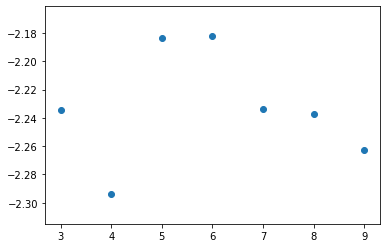

In [32]:
plt.scatter(k, umass)

In [ ]:
plt.scatter(k, cv)

In [40]:
k = range(2,10,1)
for i in k:
    print (i)

2
3
4
5
6
7
8
9


In [51]:
start = time.time()
lda_model = LdaMulticore(corpus = corp, id2word = dictionary, iterations = 1, num_topics = 6, random_state=1)
end = time.time()
print(end - start)

KeyboardInterrupt: 

In [ ]:
start = time.time()
cm1 = CoherenceModel(model = lda_model, corpus = corp, dictionary = dictionary, coherence = 'u_mass')
end = time.time()
print(end - start)

In [ ]:
start = time.time()
cm2 = CoherenceModel(model = lda_model, texts = docs, dictionary = dictionary, coherence = 'c_v')
end = time.time()
print(end - start)